<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/LeafDataSet/Test_experiments/EffB3LFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasetpath = '/content/drive/MyDrive/leaf classification'
lists = os.listdir(datasetpath)
labels = []
file_lst = []
 
for folder in lists:
    files = os.listdir(datasetpath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(df)


                                         path           label
0     Gray_Leaf_Spot/Corn_Gray_Spot (106).JPG  Gray_Leaf_Spot
1     Gray_Leaf_Spot/Corn_Gray_Spot (105).JPG  Gray_Leaf_Spot
2     Gray_Leaf_Spot/Corn_Gray_Spot (101).JPG  Gray_Leaf_Spot
3     Gray_Leaf_Spot/Corn_Gray_Spot (104).JPG  Gray_Leaf_Spot
4       Gray_Leaf_Spot/Corn_Gray_Spot (1).jpg  Gray_Leaf_Spot
...                                       ...             ...
4192  Common_Rust/Corn_Common_Rust (1277).jpg     Common_Rust
4193  Common_Rust/Corn_Common_Rust (1275).jpg     Common_Rust
4194  Common_Rust/Corn_Common_Rust (1280).jpg     Common_Rust
4195  Common_Rust/Corn_Common_Rust (1279).jpg     Common_Rust
4196  Common_Rust/Corn_Common_Rust (1269).jpg     Common_Rust

[4197 rows x 2 columns]


In [ ]:
train_df, validation_df = train_test_split(df, test_size=0.3,shuffle = True, random_state=42)
print(train_df )
print(validation_df)

                                         path           label
1226             Blight/Corn_Blight (693).JPG          Blight
1626            Blight/Corn_Blight (1069).JPG          Blight
3990  Common_Rust/Corn_Common_Rust (1084).JPG     Common_Rust
1398             Blight/Corn_Blight (850).JPG          Blight
1767            Healthy/Corn_Health (150).jpg         Healthy
...                                       ...             ...
3444   Common_Rust/Corn_Common_Rust (599).JPG     Common_Rust
466   Gray_Leaf_Spot/Corn_Gray_Spot (515).JPG  Gray_Leaf_Spot
3092   Common_Rust/Corn_Common_Rust (291).JPG     Common_Rust
3772   Common_Rust/Corn_Common_Rust (888).JPG     Common_Rust
860              Blight/Corn_Blight (348).jpg          Blight

[2937 rows x 2 columns]
                                         path           label
149   Gray_Leaf_Spot/Corn_Gray_Spot (216).jpg  Gray_Leaf_Spot
2028            Healthy/Corn_Health (370).jpg         Healthy
3770   Common_Rust/Corn_Common_Rust (885).JPG

In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/leaf classification',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/leaf classification',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 2937 validated image filenames belonging to 4 classes.
Found 1260 validated image filenames belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [ ]:
class_number = 4
def build_model_graph(class_number=class_number):
  base_model = EfficientNetB3(weights='imagenet', include_top=False,input_shape = (224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(class_number, activation='softmax')(x)
  model = Model(base_model.input, predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

43950080/43941136 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.763782 to fit



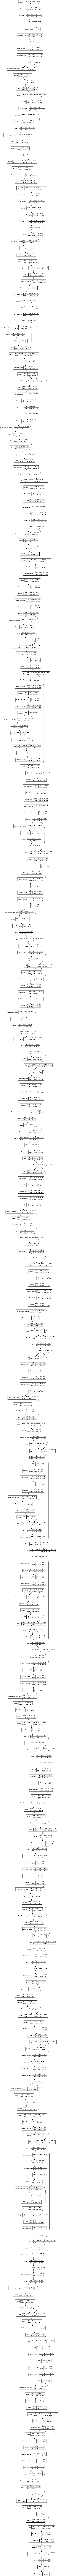

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
92/92 [==============================] - 113s 1s/step - loss: 0.0190 - accuracy: 0.9928 - val_loss: 0.9966 - val_accuracy: 0.5556
Epoch 2/15
92/92 [==============================] - 113s 1s/step - loss: 0.0096 - accuracy: 0.9980 - val_loss: 0.3339 - val_accuracy: 0.8897
Epoch 3/15
92/92 [==============================] - 113s 1s/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 1.4436 - val_accuracy: 0.3373
Epoch 4/15
92/92 [==============================] - 113s 1s/step - loss: 0.0090 - accuracy: 0.9969 - val_loss: 1.4298 - val_accuracy: 0.4079
Epoch 5/15
92/92 [==============================] - 113s 1s/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.3311 - val_accuracy: 0.8881
Epoch 6/15
92/92 [==============================] - 113s 1s/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.8499 - val_accuracy: 0.6937
Epoch 7/15
92/92 [==============================] - 113s 1s/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 1.4531 - val_accuracy: 0.2563
Epoch 8/15
92

In [ ]:
results = '/content/drive/MyDrive/PlantClassification/Results'
os.mkdir(results) 

In [ ]:
leafclassificationDataSet = '/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet'
os.mkdir(leafclassificationDataSet) 

In [ ]:
EfficientNetB3Arch = '/content/drive/MyDrive/PlantClassification/Results/EfficientNetB3Arch'
os.mkdir(EfficientNetB3Arch) 

In [ ]:
target_dir = '/content/drive/MyDrive/PlantClassification/Results/EfficientNetB3Arch'
architecture_name = "EfficientNetB3Arch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
print(hist.history)

{'loss': [0.018992843106389046, 0.009617071598768234, 0.012349802069365978, 0.009006938897073269, 0.009224162437021732, 0.014274231158196926, 0.014401061460375786, 0.00855331402271986, 0.013397838920354843, 0.010029277764260769, 0.007548721041530371, 0.010303129442036152, 0.010184693150222301, 0.011169018223881721, 0.010104814544320107], 'accuracy': [0.9928498268127441, 0.9979571104049683, 0.9969356656074524, 0.9969356656074524, 0.9969356656074524, 0.9955736994743347, 0.9962546825408936, 0.9986380934715271, 0.9962546825408936, 0.9969356656074524, 0.9979571104049683, 0.9962546825408936, 0.9969356656074524, 0.9965951442718506, 0.9969356656074524], 'val_loss': [0.9965763092041016, 0.33394384384155273, 1.4435594081878662, 1.429823875427246, 0.33110934495925903, 0.8498563170433044, 1.453133463859558, 15.043722152709961, 1.700224757194519, 0.9023087024688721, 1.023468017578125, 1.8762691020965576, 208.92897033691406, 0.3643702566623688, 0.5900831818580627], 'val_accuracy': [0.555555582046508

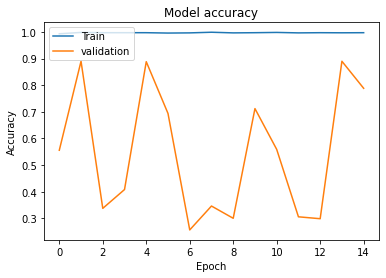

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [ ]:
hist = pd.DataFrame(hist.history)

In [ ]:
hist_csv_file = '/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/EfficientNetB3Arch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
train_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/train.csv')

In [ ]:
validation_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/validation.csv')

In [ ]:
model= model_load()

In [ ]:
img_path = '/content/drive/MyDrive/leaf classification/Common_Rust/Corn_Common_Rust (10).jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = (img_batch)*(1./255)

result = model.predict(img_preprocessed)
print(result)

[[0.00700088 0.05093358 0.05543159 0.8866339 ]]


In [ ]:
index_max=result.argmax(axis=-1)
print(index_max)

[3]


In [ ]:
print(train_generator.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [ ]:
model = load_model('/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/EfficientNetB3Arch/EfficientNetB3Arch.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________